## Hierarchical modeling

In [125]:
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
from matplotlib import pyplot as plt

In [126]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter to keep observations for "MN" state only
radon_df = radon_df[radon_df.state == "MN"].copy()

radon_df

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,5995,MN,MN,27,55363,5,1,0,4,Y,...,1730,122687,122887,6.4,4.5,1146.499190,0,0,171,WRIGHT
5995,5996,MN,MN,27,55376,5,1,0,7,Y,...,700,121787,121987,4.5,8.3,1105.956867,0,0,171,WRIGHT
5996,5997,MN,MN,27,55376,5,1,0,4,Y,...,1045,12888,13088,5.0,5.2,1214.922779,0,0,171,WRIGHT
5997,5998,MN,MN,27,56297,5,1,0,4,Y,...,940,122887,123087,3.7,9.6,1177.377355,0,0,173,YELLOW MEDICINE


| **Column** | **Description** |
|-----------|---------------|
| `stfips`  | **State FIPS code** – a unique identifier for each U.S. state. |
| `ctfips`  | **County FIPS code** – a unique identifier for each county within a state. |
| `st`      | **State abbreviation** (e.g., "MN" for Minnesota). |
| `cty`     | **County name**. |
| `lon`     | **Longitude** (geographic coordinate). |
| `lat`     | **Latitude** (geographic coordinate). |
| `Uppm`    | **Radon concentration** (measured in **picocuries per liter**, pCi/L). |

FIPS stands for **Federal Information Processing Standards**.

In the context of geographic data:

- State FIPS codes are two-digit codes assigned to each U.S. state.

- County FIPS codes are three-digit codes assigned to counties within a state.

- A full FIPS code for a county is usually a five-digit number the first two for the state and last three for the county.
For example, Hennepin County (053), Minnesota (27) has full FIPS code 27053.

In [127]:
# Add a FIPS column
radon_df["fips"] = 1_000 * radon_df.stfips + radon_df.cntyfips
radon_df["fips"]

5080    27001
5081    27001
5082    27001
5083    27001
5084    27003
        ...  
5994    27171
5995    27171
5996    27171
5997    27173
5998    27173
Name: fips, Length: 919, dtype: int64

In [128]:
# Hennepin County, MN
radon_df[radon_df["fips"] == 27053]

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
5344,5345,MN,MN,27,55316,3,0,0,0,,...,121687,121887,7.9,4.4,2246.968840,0,0,53,HENNEPIN,27053
5345,5346,MN,MN,27,55316,3,1,0,2,Y,...,11088,11288,3.3,6.2,2119.396234,0,0,53,HENNEPIN,27053
5346,5347,MN,MN,27,55316,3,1,1,3,N,...,30388,31088,2.1,12.3,2116.561544,0,0,53,HENNEPIN,27053
5347,5348,MN,MN,27,55331,3,1,0,5,Y,...,122987,123187,1.6,14.4,2116.561544,0,0,53,HENNEPIN,27053
5348,5349,MN,MN,27,55331,3,2,0,4,Y,...,10188,10188,4.0,6.0,2179.503255,0,0,53,HENNEPIN,27053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5444,5445,MN,MN,27,55444,3,0,0,0,,...,12688,12888,4.2,6.3,2179.503255,0,0,53,HENNEPIN,27053
5445,5446,MN,MN,27,55447,3,1,0,2,Y,...,11088,11288,3.8,30.5,2119.396234,0,0,53,HENNEPIN,27053
5446,5447,MN,MN,27,55447,3,1,0,4,Y,...,20288,20288,3.0,9.1,2119.396234,0,0,53,HENNEPIN,27053
5447,5448,MN,MN,27,55447,3,1,0,2,Y,...,22488,22688,4.3,8.2,2246.968840,0,0,53,HENNEPIN,27053


In [132]:
radon_df[radon_df["stfips"] == 27].groupby("cntyfips").count()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,county,fips
cntyfips,,,,,,,,,,,,,,,,,,,,,
1,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
3,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
5,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
9,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
167,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
169,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13


In [140]:
# Get city data
city_df = pd.read_csv(pm.get_data("cty.dat"))

# Add FIPS column
city_df["fips"] = 1_000 * city_df.stfips + city_df.ctfips

city_df

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
0,1,1,AL,AUTAUGA,-86.643,32.534,1.78331,1001
1,1,3,AL,BALDWIN,-87.750,30.661,1.38323,1003
2,1,5,AL,BARBOUR,-85.393,31.870,2.10105,1005
3,1,7,AL,BIBB,-87.126,32.998,1.67313,1007
4,1,9,AL,BLOUNT,-86.568,33.981,1.88501,1009
...,...,...,...,...,...,...,...,...
3189,56,37,WY,SWEETWATER,-108.879,41.660,2.42132,56037
3190,56,39,WY,TETON,-110.589,43.934,2.39226,56039
3191,56,41,WY,UINTA,-110.547,41.288,2.31204,56041
3192,56,43,WY,WASHAKIE,-107.682,43.905,2.63989,56043


In [141]:
# Merge data
df = radon_df.merge(city_df[["fips", "Uppm"]], on="fips", how="left")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Let's map floor 0 -> "Basement" and floor 1 -> "Floor"
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# Sort values by floor
df = df.sort_values(by="floor")

# Reset index
df = df.reset_index(drop=True)

df

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,log_radon
0,5540,MN,MN,27,56031,5,1,Basement,4,Y,...,4.1,5.6,1177.377355,0,0,91,MARTIN,27091,1.180410,1.435085
1,5665,MN,MN,27,55110,3,1,Basement,4,Y,...,2.7,11.0,2314.365189,0,0,123,RAMSEY,27123,0.658327,1.029619
2,5666,MN,MN,27,55112,3,1,Basement,4,Y,...,1.2,16.7,2116.561544,0,0,123,RAMSEY,27123,0.658327,0.262364
3,5667,MN,MN,27,55112,3,1,Basement,2,Y,...,3.5,6.5,2116.561544,0,0,123,RAMSEY,27123,0.658327,1.280934
4,5668,MN,MN,27,55113,3,1,Basement,2,Y,...,5.5,5.3,2179.503255,0,0,123,RAMSEY,27123,0.658327,1.722767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,5757,MN,MN,27,55731,1,1,Floor,3,Y,...,0.5,29.7,461.274696,0,0,137,ST LOUIS,27137,0.622088,-0.510826
915,5759,MN,MN,27,55732,1,1,Floor,1,Y,...,1.6,11.3,461.274696,0,0,137,ST LOUIS,27137,0.622088,0.530628
916,5765,MN,MN,27,55741,1,1,Floor,3,Y,...,0.9,35.3,461.623670,0,0,137,ST LOUIS,27137,0.622088,0.000000
917,5718,MN,MN,27,55044,5,1,Floor,1,N,...,9.1,3.7,461.274696,0,0,139,SCOTT,27139,1.065150,2.219203


In [143]:
radon_df["activity"].mean(), radon_df["activity"].var()

(4.768117519042437, 20.084592421904073)

In [144]:
radon_df["activity"]

5080    2.2
5081    2.2
5082    2.9
5083    1.0
5084    3.1
       ... 
5994    6.4
5995    4.5
5996    5.0
5997    3.7
5998    2.9
Name: activity, Length: 919, dtype: float64

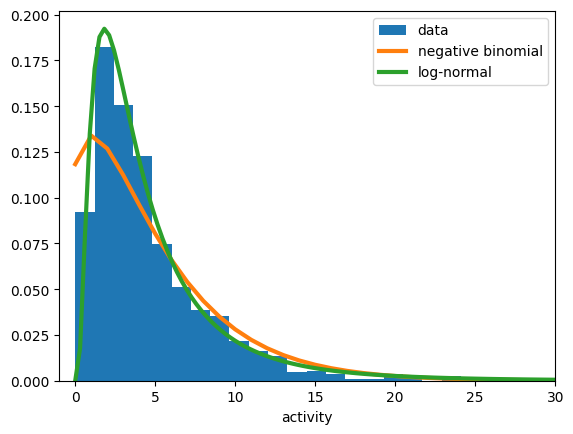

In [142]:
plt.hist(df["activity"], bins=40, density=True, label="data")

# NB fit
m = df["activity"].mean()
s = df["activity"].std()
p = m / s**2
n = m**2 / (s**2 - m)
u = np.arange(30)
plt.plot(u, stats.nbinom(n, p).pmf(u), lw=3, label="negative binomial")

# log-normal fit
u = np.linspace(0, 30, 100)
shape, loc, scale = stats.lognorm.fit(df["activity"] + 0.1, floc=0)
dist = stats.lognorm(s=shape, scale=scale)
plt.plot(u, dist.pdf(u), lw=3, label="log-normal")

plt.xlabel("activity")
plt.xlim(-1, 30)
plt.legend()
plt.show()

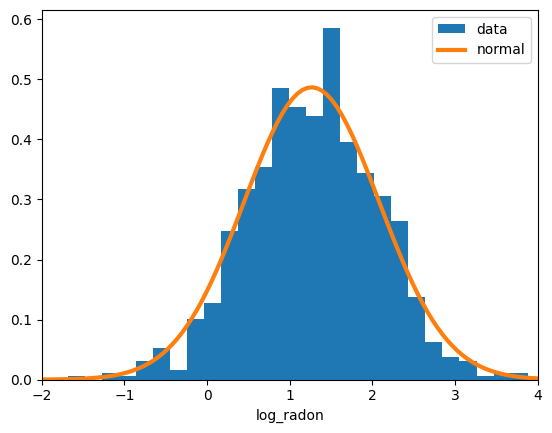

In [116]:
plt.hist(df["log_radon"], bins=30, density=True, label="data")

loc = df["log_radon"].mean()
scale = df["log_radon"].std()
dist = stats.norm(loc=loc, scale=scale)
u = np.linspace(-2, 4, 100)
plt.plot(u, dist.pdf(u), lw=3, label="normal")

plt.xlim(-2, 4)
plt.xlabel("log_radon")
plt.legend()
plt.show()

### Main floor versus basement

##### Uranium

- Radon comes from the decay of uranium in soil and rock.

- Areas with higher uranium concentrations tend to have higher radon levels.

- Use uranium concentration as a predictor for radon levels.

In [117]:
# Compute log of uranium (U) concentration in parts per million (ppm)
df["log_u"] = np.log(df["Uppm"])

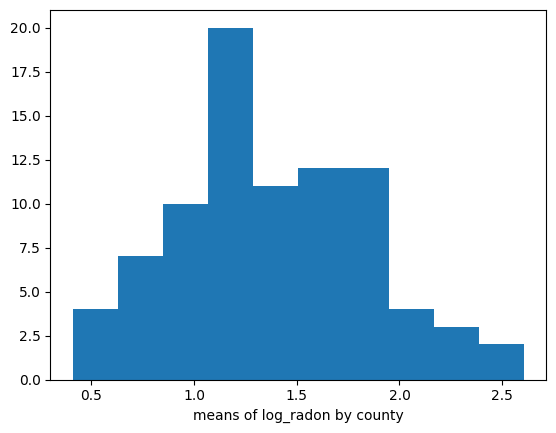

In [124]:
plt.hist(df.groupby("cntyfips")["log_radon"].mean())
plt.xlabel("means of log_radon by county")
plt.show()